In [46]:
import pandas as pd
import collections
#import pydotplus
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import os
import warnings
from itertools import combinations
from pickle import dump, load
from sklearn.feature_selection import f_regression,mutual_info_regression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.externals.six import StringIO
from decimal import *
warnings.filterwarnings('ignore')


from __future__ import print_function


In [4]:
data = pd.read_csv('data/network_backup_dataset.csv',header=None,skiprows=1,names=['Week','Day','BackupStart','WFID','FileType','Size','BackUpTime'])
data.drop('BackUpTime',axis=1,inplace=True)

In [5]:
# Functions

def plot_workflows(data):
    workflow_data = []
    uniq_wf = set(pd.unique(data['WFID']))
    for wf in uniq_wf:
        workflow_data.append(data.loc[data['WFID'] == wf])

    plt.figure(figsize=(15,15))
    for df, wf in zip(workflow_data, uniq_wf):
        temp_dt = df.groupby(['Week', 'Day'])['Size'].sum()
        plt.plot(range(1,len(temp_dt) + 1), temp_dt, label=wf)
    plt.xlabel('Days')
    plt.ylabel('Backup Sizes')
    plt.title('Days versus Backup Sizes (%d days)' %len(temp_dt))
    plt.legend(loc="best")
    plt.show()

def scatter_plot(predicted,y,color='red'):
    fig, ax = plt.subplots()
    ax.scatter(predicted,y.values,c=color,alpha=.8,lw=2,s=2)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    #ax.yaxis.set_ticks(np.linspace(y.min(),y.max(),6))
    #ax.xaxis.set_ticks(np.linspace(predicted.min(),predicted.max(),6))
    ax.set_ylabel('Actual Size')
    ax.set_xlabel('Predicted Size')
    plt.title("Fitted vs Actual plot")
    plt.show()
    
def scatter_plot_time(predicted,y,color='red'):
    fig, ax = plt.subplots()
    ax.scatter(list(range(len(predicted))),y.values,c=color,alpha=.8,lw=2,s=2,label='Actual')
    ax.scatter(list(range(len(predicted))),predicted,c='turquoise',alpha=.8,lw=2,s=2,label='Predicted')
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    #ax.yaxis.set_ticks(np.linspace(y.min(),y.max(),6))
    #ax.xaxis.set_ticks(np.linspace(predicted.min(),predicted.max(),6))
    ax.set_ylabel('Actual/Predicted Size')
    ax.set_xlabel('Data Points')
    plt.title("Fitted vs Actual plot over time")
    plt.legend(loc='best')
    plt.show()
    
def residual_plot(predicted,residual,color='turquoise'):
    fig, ax = plt.subplots()
    ax.scatter(predicted,residual,c=color,alpha=.8, lw=2,s=2)
    ax.plot([residual.min(), residual.max()], [0, 0], 'k--', lw=2)
    #ax.yaxis.set_ticks(np.linspace(residual.min(),residual.max(),6))
    #ax.xaxis.set_ticks(np.linspace(predicted.min(),predicted.max(),6))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residual')
    plt.title("Residual vs Fitted plot")
    plt.show()
    
def residual_plot_time(predicted,residual,color='turquoise'):
    fig, ax = plt.subplots()
    ax.scatter(list(range(len(predicted))),predicted,c=color,alpha=.8, lw=2,s=2,label='Predicted')
    ax.scatter(list(range(len(predicted))),residual,c='yellow',alpha=.8, lw=2,s=2,label='Residual')
    #ax.plot([residual.min(), residual.max()], [0, 0], 'k--', lw=2)
    #ax.yaxis.set_ticks(np.linspace(residual.min(),residual.max(),6))
    #ax.xaxis.set_ticks(np.linspace(predicted.min(),predicted.max(),6))
    plt.legend(loc='best')
    plt.title("Residual vs Fitted over time plot")
    ax.set_ylabel('Residual/Predicted Size')
    ax.set_xlabel('Data Points')
    plt.show()

def scalar_encoding(data,columns):
    for col in columns:
        data[col] = data[col].astype('category')
        data[col] = data[col].cat.codes

def onehot_encoding(data,columns):
    if(len(columns)==0):
        return data
    new_data = pd.get_dummies(data, columns=columns)
    return new_data

def generate_combinations(data,columns,save=False):
    outer = len(columns)+1
    count = 0
    suffix = '.csv'
    prefix = 'data/dataset-'
    multi_dataset = {}
    for i in range(outer):
        combns = combinations(columns,i)
        for j in combns:
            new_data = onehot_encoding(data,list(j))
            if(save):
                count += 1
                new_data.to_csv(''.join([prefix,str(count),suffix]),index=False)
            multi_dataset[j] = new_data
    return multi_dataset

# Task 1: Plot Workflows

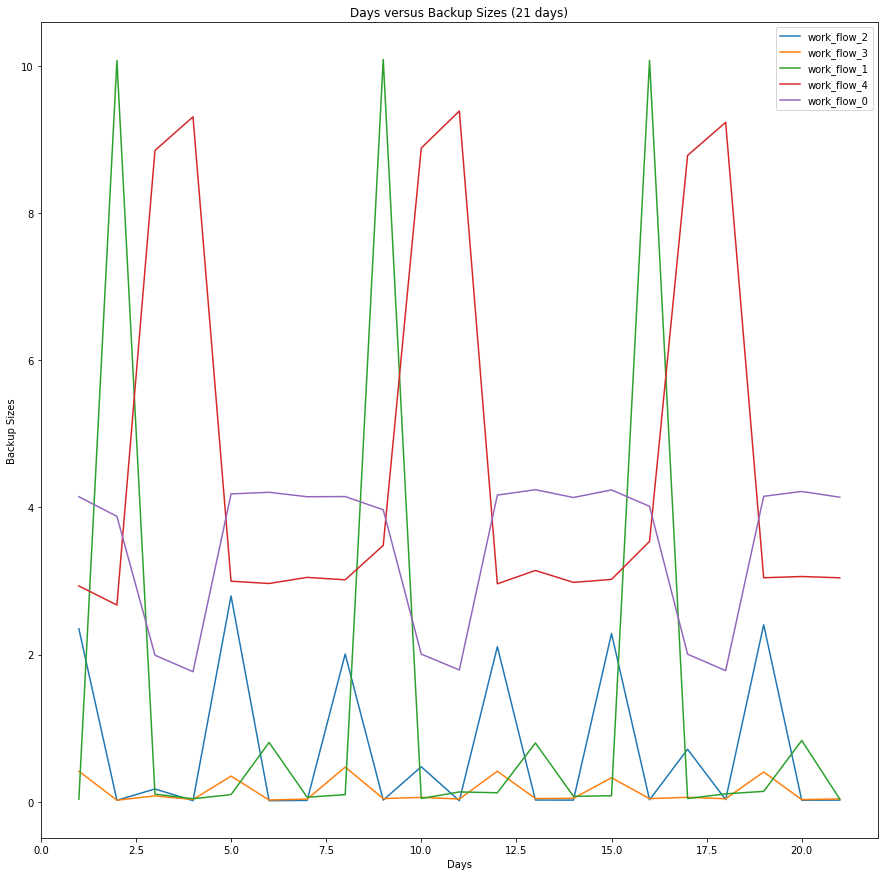

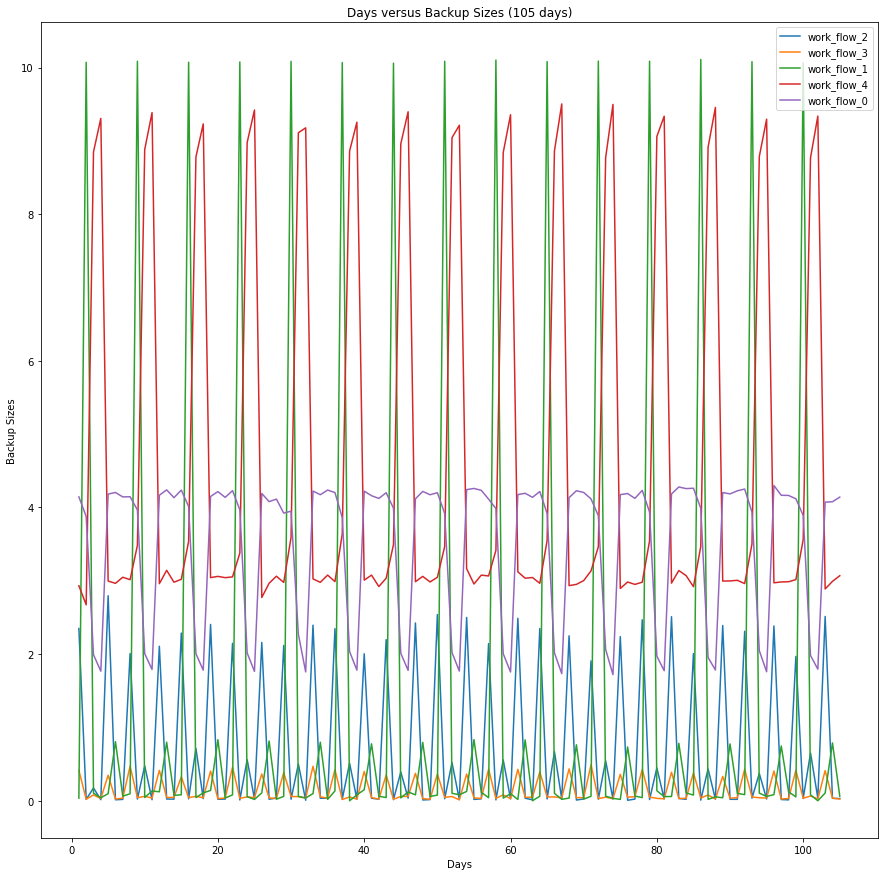

In [4]:
twenty_data = data.loc[data['Week'].isin([1,2,3])]
plot_workflows(twenty_data)
plot_workflows(data)

# Task 2: Predict the backup size

In [6]:
def preprocess(data,save=False):
    categorical = ['Week','Day','BackupStart','WFID','FileType']
    scalar_encoding(data,categorical)
    multi_dataset = generate_combinations(data,categorical,save)
    return multi_dataset

def linear_regression2(regressor,X,y,cv,feature_selection=None,verbose=True,printing=True,shuffle=True):
    if(printing):
        print(regressor)   
    kf = KFold(n_splits=cv,shuffle=shuffle)
    train_rmse, test_rmse,coeffs,intercept = [],[],[],[]
    columns = X.columns.values
    coeffs = {col:[] for col in columns}
    for k,(train_index,test_index) in enumerate(kf.split(X)):
        training_X, training_y = X.loc[train_index].values,y.loc[train_index].values
        testing_X, testing_y = X.loc[test_index].values,y.loc[test_index].values
        regressor.fit(training_X,training_y)
        coefficient = regressor.named_steps['regression'].coef_[0]
        for c,col in zip(coefficient,columns):
            coeffs[col].append(c)
        intercept.append(regressor.named_steps['regression'].intercept_)
        if(feature_selection is not None):
            features = regressor.named_steps['feature_selection'].get_support()
            best_k_features = columns[np.where(features==True)[0]]
        prediction_train = regressor.predict(training_X)    
        prediction_test = regressor.predict(testing_X)    
        k_train_rmse = np.sqrt(metrics.mean_squared_error(training_y, prediction_train))
        k_test_rmse = np.sqrt(metrics.mean_squared_error(testing_y, prediction_test))
        if(verbose):
            print("[fold {0}] Train_RMSE: {1:.5f}, Test_RMSE: {2:.5f}".
                  format(k,k_train_rmse,k_test_rmse))
        train_rmse.append(k_train_rmse)
        test_rmse.append(k_test_rmse)
        
    avg_train_rmse = np.round(np.mean(train_rmse),5)
    avg_test_rmse = np.round(np.mean(test_rmse),5)
    avg_coeffs = {}
    for k,v in coeffs.items():
        avg_coeffs[k] = np.round(np.mean(v),5)
    avg_intercept = np.round(np.mean(intercept),5)
    if(printing):
        print('Average Train RMSE =',avg_train_rmse)
        print('Average Test RMSE =',avg_test_rmse)
        if(feature_selection is None):
            print('Coefficients = ',avg_coeffs)
            print('Intercept =',avg_intercept)
    if(feature_selection is not None):
        return [avg_train_rmse, avg_test_rmse, best_k_features]
    return [avg_train_rmse,avg_test_rmse]


In [7]:
multi_dataset = preprocess(data,save=False)

## Part (2a) (i) - Baseline

In [31]:
baseline_data = pd.read_csv('data/dataset-1.csv')
X = baseline_data.loc[:, baseline_data.columns != 'Size']
y = baseline_data.loc[:, baseline_data.columns == 'Size']

Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
[fold 0] Train_RMSE: 0.10259, Test_RMSE: 0.09485
[fold 1] Train_RMSE: 0.10119, Test_RMSE: 0.10755
[fold 2] Train_RMSE: 0.10133, Test_RMSE: 0.10634
[fold 3] Train_RMSE: 0.10226, Test_RMSE: 0.09796
[fold 4] Train_RMSE: 0.10101, Test_RMSE: 0.10908
[fold 5] Train_RMSE: 0.10178, Test_RMSE: 0.10236
[fold 6] Train_RMSE: 0.10147, Test_RMSE: 0.10516
[fold 7] Train_RMSE: 0.10218, Test_RMSE: 0.09871
[fold 8] Train_RMSE: 0.10224, Test_RMSE: 0.09815
[fold 9] Train_RMSE: 0.10233, Test_RMSE: 0.09734
Average Train RMSE = 0.10184
Average Test RMSE = 0.10175
Coefficients =  {'Week': 2e-05, 'Day': -0.00568, 'BackupStart': 0.00549, 'WFID': 0.00185, 'FileType': 0.00185}
Intercept = 0.03367


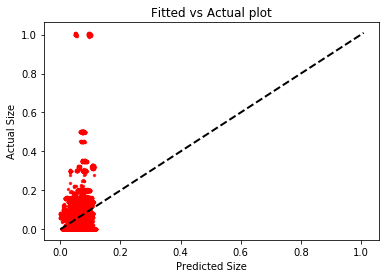

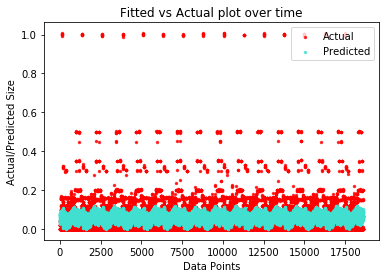

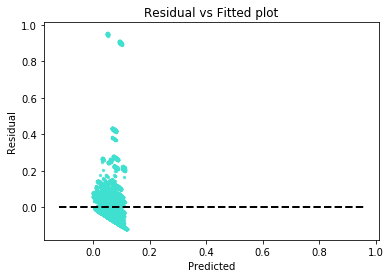

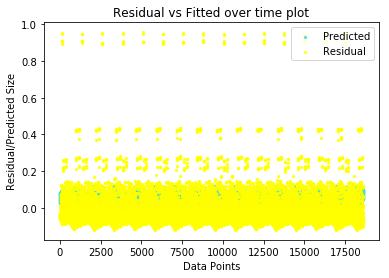

In [9]:
baselineRegressor = Pipeline([('regression',LinearRegression())])
linear_regression2(baselineRegressor,X,y,10)

#Plots for Part (a)(i) - Baseline Regressor
baseline_predicted = cross_val_predict(baselineRegressor,  X, y, cv=10)
baseline_residual = y.values-baseline_predicted
scatter_plot(baseline_predicted,y)
scatter_plot_time(baseline_predicted,y)
residual_plot(baseline_predicted,baseline_residual)
residual_plot_time(baseline_predicted,baseline_residual)

## Part (2a) (ii) - Standardized Data 

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
[fold 0] Train_RMSE: 0.10220, Test_RMSE: 0.09855
[fold 1] Train_RMSE: 0.10192, Test_RMSE: 0.10111
[fold 2] Train_RMSE: 0.10136, Test_RMSE: 0.10611
[fold 3] Train_RMSE: 0.10210, Test_RMSE: 0.09947
[fold 4] Train_RMSE: 0.10167, Test_RMSE: 0.10336
[fold 5] Train_RMSE: 0.10171, Test_RMSE: 0.10304
[fold 6] Train_RMSE: 0.10219, Test_RMSE: 0.09865
[fold 7] Train_RMSE: 0.10181, Test_RMSE: 0.10213
[fold 8] Train_RMSE: 0.10143, Test_RMSE: 0.10543
[fold 9] Train_RMSE: 0.10198, Test_RMSE: 0.10053
Average Train RMSE = 0.10184
Average Test RMSE = 0.10184
Coefficients =  {'Week': 6.9999999999999994e-05, 'BackupStart': 0.0093900000000000008, 'FileType': 0.01593, 'WFID': 0.0026199999999999999, 'Day': -0.011350000000000001}
Intercept = 0.06098


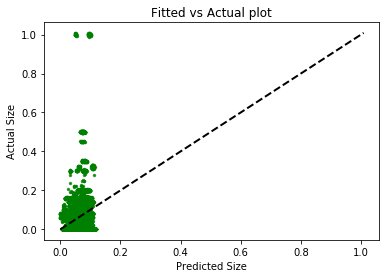

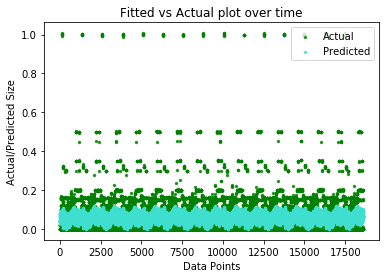

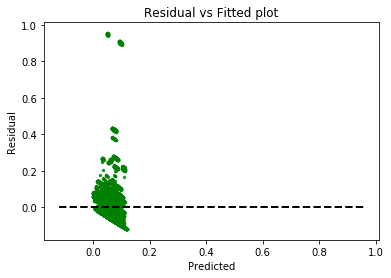

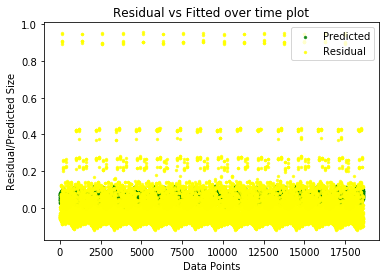

In [13]:
scaledRegressor = Pipeline([('scaler',StandardScaler()),('regression',LinearRegression())])
linear_regression2(scaledRegressor,X,y,10)
#Plots for Part (a)(ii) - Standard Scaled Regressor
standard_predicted = cross_val_predict(scaledRegressor,  X, y, cv=10)
standard_residual = y.values-standard_predicted

scatter_plot(standard_predicted,y,color='green')
scatter_plot_time(standard_predicted,y,color='green')
residual_plot(standard_predicted,standard_residual,color='green')
residual_plot_time(standard_predicted,standard_residual,color='green')

## Part (iii) - Feature Selection using f_regression

In [10]:
imp_features = SelectKBest(f_regression, k=3)
lr = LinearRegression()
regressor = Pipeline([('feature_selection', imp_features),
                ('regression', lr)])
train_rmse,test_rmse,features = linear_regression2(regressor,X,y,10,
                                                          feature_selection=True,verbose=False)
print('Selected Features = ',features)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=3, score_func=<function f_regression at 0x00000167020F1D90>)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.10187
Average Test RMSE = 0.10175
Coefficients =  {'Week': -0.00567, 'Day': 0.0055, 'BackupStart': 0.00188, 'WFID': nan, 'FileType': nan}
Intercept = 0.03711
Selected Features =  ['Day' 'BackupStart' 'FileType']


## Feature selection using Mutual Information 

In [11]:
imp_features = SelectKBest(mutual_info_regression, k=3)
lr = LinearRegression()
regressor = Pipeline([('feature_selection', imp_features),
                ('regression', lr)])
train_rmse,test_rmse,features = linear_regression2(regressor,X,y,10,
                                                          feature_selection=True,verbose=True)
print('Selected Features = ',features)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=3,
      score_func=<function mutual_info_regression at 0x0000016702258730>)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
[fold 0] Train_RMSE: 0.10326, Test_RMSE: 0.09508
[fold 1] Train_RMSE: 0.10233, Test_RMSE: 0.10371
[fold 2] Train_RMSE: 0.10250, Test_RMSE: 0.10224
[fold 3] Train_RMSE: 0.10153, Test_RMSE: 0.11064
[fold 4] Train_RMSE: 0.10334, Test_RMSE: 0.09426
[fold 5] Train_RMSE: 0.10308, Test_RMSE: 0.09684
[fold 6] Train_RMSE: 0.10220, Test_RMSE: 0.10487
[fold 7] Train_RMSE: 0.10122, Test_RMSE: 0.11311
[fold 8] Train_RMSE: 0.10212, Test_RMSE: 0.10562
[fold 9] Train_RMSE: 0.10308, Test_RMSE: 0.09677
Average Train RMSE = 0.10247
Average Test RMSE = 0.10231
Coefficients =  {'Week': 0.00543, 'Day': 0.0018, 'BackupStart': 0.00186, 'WFID': nan, 'FileType': nan}
Intercept = 0.01696
Selected Features =  ['BackupStart' 'WFID' 'FileType']


## Part (iv) - Feature Encoding

('Week', 'BackupStart')
__________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.10058
Average Test RMSE = 0.10904
Coefficients =  {'Week_14': -0.0017899999999999999, 'Week_13': -0.00157, 'Week_12': -0.0018500000000000001, 'Week_11': -0.001, 'Week_10': -0.0020999999999999999, 'Week_0': -0.0024199999999999998, 'BackupStart_4': -0.0033800000000000002, 'BackupStart_5': 0.00266, 'BackupStart_2': 0.0078100000000000001, 'BackupStart_3': 0.033509999999999998, 'BackupStart_0': -0.02019, 'BackupStart_1': -0.020400000000000001, 'WFID': 0.00197, 'FileType': 0.0018500000000000001, 'Week_9': -0.0015, 'Week_8': 0.010630000000000001, 'Week_7': -0.00073999999999999999, 'Week_6': -0.00167, 'Week_5': 0.010200000000000001, 'Week_4': -0.00134, 'Week_3': -0.0019599999999999999, 'Week_2': -0.0012600000000000001, 'Week_1': -0.0016100000000000001, 'Day': -0.00574000

Average Train RMSE = 0.09963
Average Test RMSE = 4127647143.52
Coefficients =  {'Week_14': -1372186737.15115, 'Week_13': -1406832086.11186, 'Week_12': -1168444518.8122001, 'Week_11': -1335212673.7906001, 'Week_10': -1406832086.1124001, 'BackupStart_4': -1113653013.6601, 'BackupStart_5': -1113653013.6551399, 'BackupStart_2': -1113653013.6496201, 'BackupStart_3': -1113653013.62397, 'BackupStart_0': -1113653013.6776199, 'BackupStart_1': -1113653013.6778901, 'WFID': 0.00191, 'FileType': 0.0018600000000000001, 'Day_2': -110443741.75835, 'Day_3': -110443741.76013, 'Day_0': -110443741.767, 'Day_1': -110443741.72152001, 'Day_6': -110443741.78179, 'Day_4': -110443741.76681, 'Day_5': -110443741.77517, 'Week_9': -1659877248.0119801, 'Week_8': -1406832086.09974, 'Week_7': -1406832086.1110301, 'Week_6': -1320783856.7202799, 'Week_5': -1406832086.1001301, 'Week_4': -1406832086.11163, 'Week_3': -957295423.28665996, 'Week_2': -1843992405.2804501, 'Week_1': -1406832086.1119101, 'Week_0': 2075778118.926

Average Train RMSE = 0.08977
Average Test RMSE = 89834552977.5
Coefficients =  {'BackupStart': 0.0055300000000000002, 'Week_14': 27263668273.986252, 'Week_13': 27086751794.288441, 'Week_12': 23189554693.597801, 'Week_11': 66935149571.0009, 'Week_10': 27086751794.287998, 'FileType_15': 27951629274.190762, 'FileType_14': 27951629274.1908, 'FileType_17': 29748030438.754688, 'FileType_16': 27951629274.19099, 'FileType_11': 27951629274.191078, 'FileType_10': 27951629274.1908, 'FileType_13': 27951629274.191158, 'FileType_12': 2490068960.4356298, 'FileType_19': 29748030438.755428, 'FileType_18': 29748030438.75523, 'FileType_1': 2490068960.43611, 'FileType_0': 2490068960.43472, 'FileType_3': 20026941738.52174, 'FileType_2': 20026941738.521671, 'FileType_5': 21838953836.650249, 'FileType_4': 21838953836.64986, 'FileType_7': 21838953836.649719, 'FileType_6': 21838953836.6507, 'FileType_9': 21838953836.650742, 'FileType_8': 21838953836.652161, 'Day_2': 193257108608.95612, 'WFID_4': -5461363904.35

Average Train RMSE = 0.09079
Average Test RMSE = 0.09083
Coefficients =  {'BackupStart': 0.0055599999999999998, 'FileType_15': -383623780.20792001, 'FileType_14': -383623780.20787001, 'FileType_17': -542563267.77061999, 'FileType_16': -383623780.20765001, 'FileType_11': -383623780.20757002, 'FileType_10': -383623780.20789999, 'FileType_13': -383623780.20750999, 'FileType_12': 93194682.965299994, 'FileType_19': -542563267.76986003, 'FileType_18': -542563267.77005005, 'Week': 2.0000000000000002e-05, 'FileType_1': 93194682.965680003, 'FileType_0': 93194682.964369997, 'FileType_3': -65744804.78001, 'FileType_2': -65744804.780340001, 'FileType_5': -224684292.49845999, 'FileType_4': -224684292.49908999, 'FileType_7': -224684292.49911001, 'FileType_6': -224684292.49797001, 'FileType_9': -224684292.49797001, 'FileType_8': -224684292.49664, 'Day': -0.0055399999999999998, 'WFID': 158939487.69247001, 'FileType_20': -542563267.77093005, 'FileType_21': -542563267.77028, 'FileType_22': -542563267.77

Average Train RMSE = 0.08939
Average Test RMSE = 103651914651.0
Coefficients =  {'Week_14': 42120392144.082359, 'Week_13': 18819703518.450951, 'Week_12': 59478615811.138649, 'Week_11': 9618534953.0109596, 'Week_10': 18819703518.4505, 'FileType_15': -7836965061.3312702, 'FileType_14': -7836965061.3312798, 'FileType_17': 3303133046.3551402, 'FileType_16': -7836965061.3310299, 'FileType_11': -7836965061.3310299, 'FileType_10': -7836965061.33144, 'FileType_13': -7836965061.3309202, 'FileType_12': 5459822482.5934095, 'Week_0': 37734488109.366882, 'FileType_19': 3303133046.3559699, 'FileType_18': 3303133046.3557401, 'FileType_1': 5459822482.5937901, 'FileType_0': 5459822482.5924997, 'FileType_3': 7978515696.5558701, 'FileType_2': 7978515696.5554504, 'FileType_5': 17096041507.519369, 'FileType_4': 17096041507.5191, 'FileType_7': 17096041507.51869, 'FileType_6': 17096041507.5208, 'FileType_9': 17096041507.52022, 'FileType_8': 17096041507.521469, 'BackupStart_4': 60235796265.055862, 'BackupStar

Average Train RMSE = 0.09079
Average Test RMSE = 0.09083
Coefficients =  {'BackupStart': 0.0055599999999999998, 'FileType_15': -328565835.64355999, 'FileType_14': -328565835.64352, 'FileType_17': -3688672642.8057699, 'FileType_16': -328565835.64328998, 'FileType_11': -328565835.64322001, 'FileType_10': -328565835.64354998, 'FileType_13': -328565835.64318001, 'FileType_12': -940496351.12056005, 'FileType_19': -3688672642.8050299, 'FileType_18': -3688672642.8052001, 'Week': 2.0000000000000002e-05, 'FileType_1': -940496351.12018001, 'FileType_0': -940496351.12147999, 'FileType_3': 3181328105.7676401, 'FileType_2': 3181328105.7673001, 'FileType_5': 1191952393.65622, 'FileType_4': 1191952393.6555901, 'FileType_7': 1191952393.65558, 'FileType_6': 1191952393.6566999, 'FileType_9': 1191952393.6567099, 'FileType_8': 1191952393.65804, 'Day': -0.0055399999999999998, 'WFID_4': -2639577682.5415802, 'WFID_3': -5999684489.83356, 'WFID_2': -7520202719.1163502, 'WFID_1': -9509578431.2017593, 'WFID_0': 

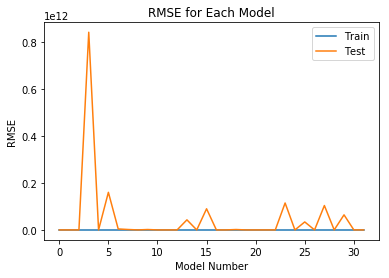

In [8]:
train_rmse,test_rmse = {},{}
for combn,dataset in multi_dataset.items():
    print(combn)
    print('_'*50)
    #X = dataset.loc[:, dataset.columns != 'Size']
    #y = dataset.loc[:, dataset.columns == 'Size']
    
    X = dataset.drop(['Size'],axis=1)
    y = dataset.loc[:, dataset.columns == 'Size']
    
    lr = LinearRegression()
    regressor = Pipeline([('regression', lr)])
    train_rmse[combn],test_rmse[combn] = linear_regression2(regressor,X,y,10,verbose=False,shuffle=False)
    print('_'*50)
    
fig = plt.figure()    
plt.plot(train_rmse.values(),label='Train')
plt.plot(test_rmse.values(),label='Test')
plt.xlabel('Model Number')
plt.ylabel('RMSE')
plt.title('RMSE for Each Model')
plt.legend(loc='best')
plt.show()

## Part (v) - Controlling ill conditioning and overfitting

### Lasso Regression

BEST RESULTS FOR LASSO CV!!!
Model = ('Day', 'BackupStart', 'WFID', 'FileType')
RMSE = 0.0885045028052
Alpha = 2.25183926814e-05
Coefficients are :
['Week' 'Size' 'Day_0' 'Day_1' 'Day_2' 'Day_3' 'Day_4' 'Day_5' 'Day_6'
 'BackupStart_0' 'BackupStart_1' 'BackupStart_2' 'BackupStart_3'
 'BackupStart_4' 'BackupStart_5' 'WFID_0' 'WFID_1' 'WFID_2' 'WFID_3'
 'WFID_4' 'FileType_0' 'FileType_1' 'FileType_2' 'FileType_3' 'FileType_4'
 'FileType_5' 'FileType_6' 'FileType_7' 'FileType_8' 'FileType_9'
 'FileType_10' 'FileType_11' 'FileType_12' 'FileType_13' 'FileType_14'
 'FileType_15' 'FileType_16' 'FileType_17' 'FileType_18' 'FileType_19'
 'FileType_20' 'FileType_21' 'FileType_22' 'FileType_23' 'FileType_24'
 'FileType_25' 'FileType_26' 'FileType_27' 'FileType_28' 'FileType_29']
[  1.00042940e-05  -3.01514189e-04   4.44046523e-02   8.37054226e-03
   6.59005003e-03   0.00000000e+00  -7.44340933e-03  -1.48636910e-02
  -2.19474594e-02  -2.27947812e-02   5.78335658e-03   3.14466085e-02
  -3.72411469e

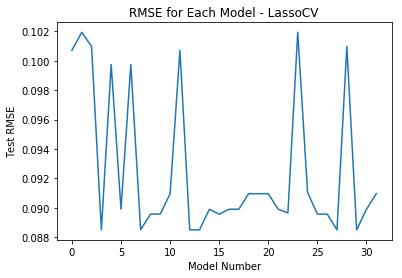

In [20]:
lasso_test_rmse = []
lasso_alphas = []
lasso_coefs = []
for combn,dataset in multi_dataset.items():
    #print('_'*50)
    #print(combn)
    #X = dataset.loc[:, dataset.columns != 'Size']
    #y = dataset.loc[:, dataset.columns == 'Size']
    
    X = dataset.drop(['Size'],axis=1)
    y = dataset.loc[:, dataset.columns == 'Size']
    
    model = LassoCV(cv=10).fit(X, y)
    m_log_alphas = -np.log10(model.alphas_)
    index = np.argmin(model.mse_path_.mean(axis=-1))
    #print('Best Alpha =',model.alphas_[index])
    lasso_alphas.append(model.alphas_[index])
    #print('Log Alpha =',-np.log10(model.alphas_[index]))
    lasso_test_rmse.append(np.sqrt(model.mse_path_.mean(axis=-1).min()))
    lasso_coefs.append(model.coef_)
    #print('RMSE = ',lasso_test_rmse[-1])
"""    plt.plot(m_log_alphas, np.sqrt(model.mse_path_.mean(axis=-1)), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
    plt.legend(loc='best')
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.axis('tight')
    plt.title(list(combn))
    plt.show()"""
    #print('_'*50)

print('BEST RESULTS FOR LASSO CV!!!')
index = np.argmin(lasso_test_rmse)
print('Model =', list(multi_dataset.keys())[index])
print('RMSE =',min(lasso_test_rmse))
print('Alpha =',lasso_alphas[index])
print('Coefficients are :')
print(list(multi_dataset.values())[index].columns.values)
print(lasso_coefs[index])

fig = plt.figure()    
plt.plot(lasso_test_rmse,label='Test')
plt.xlabel('Model Number')
plt.ylabel('Test RMSE')
plt.title('RMSE for Each Model - LassoCV')
plt.show()

### Ridge Regression

BEST RESULTS FOR RIDGE CV!!!
Model = ('Week', 'Day', 'BackupStart', 'WFID', 'FileType')
RMSE = 0.0883437430779
Alpha = 10
Coefficients are :
['Size' 'Week_0' 'Week_1' 'Week_2' 'Week_3' 'Week_4' 'Week_5' 'Week_6'
 'Week_7' 'Week_8' 'Week_9' 'Week_10' 'Week_11' 'Week_12' 'Week_13'
 'Week_14' 'Day_0' 'Day_1' 'Day_2' 'Day_3' 'Day_4' 'Day_5' 'Day_6'
 'BackupStart_0' 'BackupStart_1' 'BackupStart_2' 'BackupStart_3'
 'BackupStart_4' 'BackupStart_5' 'WFID_0' 'WFID_1' 'WFID_2' 'WFID_3'
 'WFID_4' 'FileType_0' 'FileType_1' 'FileType_2' 'FileType_3' 'FileType_4'
 'FileType_5' 'FileType_6' 'FileType_7' 'FileType_8' 'FileType_9'
 'FileType_10' 'FileType_11' 'FileType_12' 'FileType_13' 'FileType_14'
 'FileType_15' 'FileType_16' 'FileType_17' 'FileType_18' 'FileType_19'
 'FileType_20' 'FileType_21' 'FileType_22' 'FileType_23' 'FileType_24'
 'FileType_25' 'FileType_26' 'FileType_27' 'FileType_28' 'FileType_29']
[[ -7.83199355e-04  -3.94976577e-05   3.47525492e-04  -3.47561001e-04
    3.27679475e-04  -2.

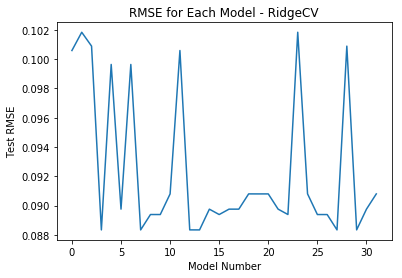

In [21]:
ridge_test_rmse = []
ridge_alphas = []
ridge_coefs = []
for combn,dataset in multi_dataset.items():
    #print('_'*50)
    #print(combn)
    X = dataset.drop(['Size'],axis=1)
    y = dataset.loc[:, dataset.columns == 'Size']
    
    model = RidgeCV(alphas=[10**k for k in range(-3,2)],cv=10,scoring='neg_mean_squared_error').fit(X, y)
    #print('Alpha =',model.alpha_)
    ridge_alphas.append(model.alpha_)
    ridge_test_rmse.append(np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=model.predict(X))))
    ridge_coefs.append(model.coef_)
    #print('RMSE =',ridge_test_rmse[-1])
    #print('_'*50)
    
print('BEST RESULTS FOR RIDGE CV!!!')
index = np.argmin(ridge_test_rmse)
print('Model =', list(multi_dataset.keys())[index])
print('RMSE =',min(ridge_test_rmse))
print('Alpha =',ridge_alphas[index])
print('Coefficients are :')
print(list(multi_dataset.values())[index].columns.values)
print(ridge_coefs[index])

fig = plt.figure()    
plt.plot(ridge_test_rmse,label='Test')
plt.xlabel('Model Number')
plt.ylabel('Test RMSE')
plt.title('RMSE for Each Model - RidgeCV')
plt.show()

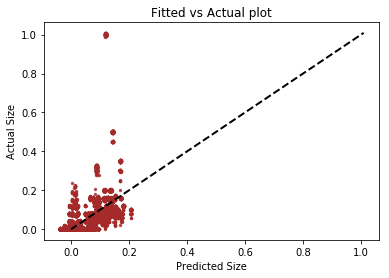

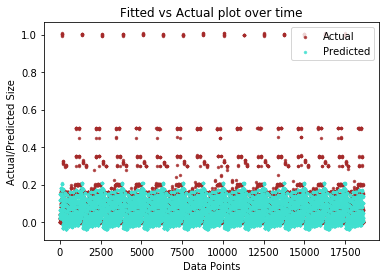

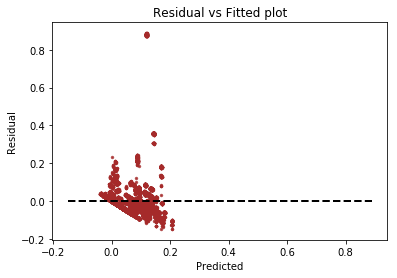

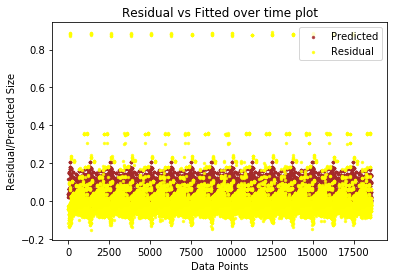

In [23]:
# Best model is obtained from RidgeCV. Plot scatter, residual plots for that.

dataset = multi_dataset.values()[index]
X = dataset.drop(['Size'],axis=1)
y = dataset.loc[:, dataset.columns == 'Size']
    
model = RidgeCV(alphas=[10**k for k in range(-3,2)],cv=10,scoring='neg_mean_squared_error').fit(X, y)
predicted = model.predict(X)

residual = y.values-predicted

scatter_plot(predicted,y,color='brown')
scatter_plot_time(predicted,y,color='brown')
residual_plot(predicted,residual,color='brown')
residual_plot_time(predicted,residual,color='brown')

# Part: (2b): Random Forest Regression

# Part: (2b) (i):

In [8]:
data = pd.read_csv('data/dataset-1.csv')
X = data.loc[:, data.columns != 'Size']
y = data.loc[:, data.columns == 'Size']

kf = KFold(n_splits=10)
kf.get_n_splits(X)
rf_models = []
train_mse = []
test_mse = []
for train_index, test_index in kf.split(X):
    #print(train_index, test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = RandomForestRegressor(n_estimators=20, max_depth=4, max_features=5, bootstrap=True, oob_score=True, verbose=False)
    y_pred = model.fit(X_train, np.array(y_train).ravel()).predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_pred))
    y_pred = model.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_pred))
    rf_models.append(model)

In [9]:
test_rmse = [x**(0.5) for x in test_mse]
avg_test_rmse = sum(test_rmse)/len(test_rmse)

train_rmse = [x**(0.5) for x in train_mse]
avg_train_rmse = sum(train_rmse)/len(train_rmse)

print('Average Test RMSE: %0.8f and Train RMSE is: %0.8f' %(avg_test_rmse,avg_train_rmse))

oob_score = []
for model in rf_models:
    oob_score.append(model.oob_score_)
oob_score = [1-x for x in oob_score]
oob_score = sum(oob_score)/len(oob_score)
print('OOB Score is:', oob_score, sep = '')

Average Test RMSE: 0.07598931 and Train RMSE is: 0.07591471
OOB Score is:0.5331032542144255


# Part: (2b) (ii): Sweep over 1-200 trees and 1-5 features and plot RMSE and OOB

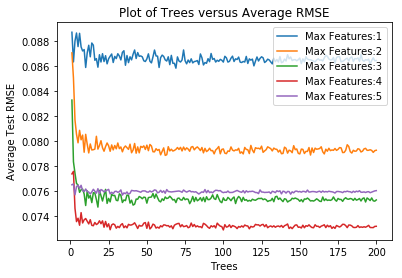

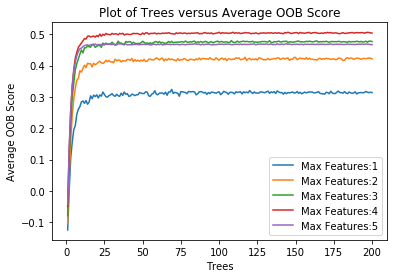

In [10]:
load_data = True
if not load_data:
    data = pd.read_csv('data/dataset-1.csv')
    X = data.loc[:, data.columns != 'Size']
    y = data.loc[:, data.columns == 'Size']

    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    rf_models = []
    store_rmse = []
    store_oob = []
    no_of_features = list(range(1,6))
    no_of_trees = list(range(1,201))
    for feat in no_of_features:
        print(feat)
        test_rmse = []
        oob_sc = []
        for trees in no_of_trees:
            cv_test_mse = []
            cv_oob_score = []
            model = RandomForestRegressor(n_estimators=trees, max_depth=4, max_features=feat, 
                                          bootstrap=True, oob_score=True, verbose=False)
            for train_index, test_index in kf.split(X):
                #print(train_index, test_index)
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, np.array(y_train).ravel())
                y_pred = model.predict(X_test)
                cv_test_mse.append(mean_squared_error(y_test, y_pred))
                cv_oob_score.append(model.oob_score_)

            avg_test_rmse = sum([x**0.5 for x in cv_test_mse])/len(cv_test_mse)
            avg_oob_score = sum(cv_oob_score)/len(cv_oob_score)
            test_rmse.append(avg_test_rmse)
            oob_sc.append(avg_oob_score)
        store_rmse.append(test_rmse)
        store_oob.append(oob_sc)
    
    #Save the Lists
    with open('models/rf_tree_feat_rmse.pkl', 'wb') as f:
        dump(store_rmse, f)
    with open('models/rf_tree_feat_oob.pkl', 'wb') as f:
        dump(store_oob, f)
        
else:        
    with open('models/rf_tree_feat_rmse.pkl', 'rb') as f:
        store_rmse = load(f)
    with open('models/rf_tree_feat_oob.pkl', 'rb') as f:
        store_oob = load(f)

#plt.figure(figsize=(15,8))
for counter, i in enumerate(store_rmse):
    plt.plot(range(1,len(i) + 1), i, label='Max Features:%d' %(counter+1))
    plt.xlabel('Trees')
    plt.ylabel('Average Test RMSE')
    plt.title('Plot of Trees versus Average RMSE')
    plt.legend(loc="best")
plt.show()

#plt.figure(figsize=(15,8))
for counter, i in enumerate(store_oob):
    plt.plot(range(1,len(i) + 1), i, label='Max Features:%d' %(counter+1))
    plt.xlabel('Trees')
    plt.ylabel('Average OOB Score')
    plt.title('Plot of Trees versus Average OOB Score')
    plt.legend(loc="best")
plt.show()


# Part: (2b) (iii): Sweep over 1-200 trees and 1-5 depth and plot RMSE and OOB

1
2
3
4
5


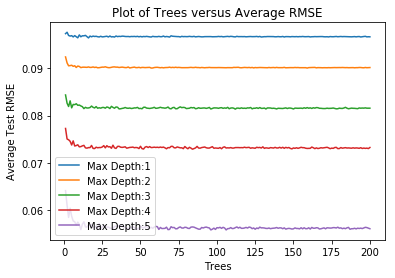

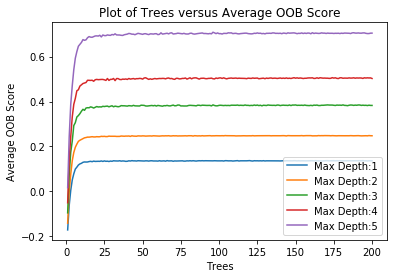

In [11]:
load_data = True
if not load_data:
    data = pd.read_csv('data/dataset-1.csv')
    X = data.loc[:, data.columns != 'Size']
    y = data.loc[:, data.columns == 'Size']

    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    rf_models = []
    store_rmse = []
    store_oob = []
    no_of_depths = list(range(1,6))
    no_of_trees = list(range(1,201))
    for depth in no_of_depths:
        print(depth)
        test_rmse = []
        oob_sc = []
        for trees in no_of_trees:
            cv_test_mse = []
            cv_oob_score = []
            model = RandomForestRegressor(n_estimators=trees, max_features=4, max_depth=depth,
                                          bootstrap=True, oob_score=True, verbose=False)
            for train_index, test_index in kf.split(X):
                #print(train_index, test_index)
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, np.array(y_train).ravel())
                y_pred = model.predict(X_test)
                cv_test_mse.append(mean_squared_error(y_test, y_pred))
                cv_oob_score.append(model.oob_score_)

            avg_test_rmse = sum([x**0.5 for x in cv_test_mse])/len(cv_test_mse)
            avg_oob_score = sum(cv_oob_score)/len(cv_oob_score)
            test_rmse.append(avg_test_rmse)
            oob_sc.append(avg_oob_score)
        store_rmse.append(test_rmse)
        store_oob.append(oob_sc)
    
    #Save the lists
    with open('models/rf_tree_depth_rmse.pkl', 'wb') as f:
        dump(store_rmse, f)
    with open('models/rf_tree_depth_oob.pkl', 'wb') as f:
        dump(store_oob, f)

else:
    with open('models/rf_tree_depth_rmse.pkl', 'rb') as f:
        store_rmse = load(f)
    with open('models/rf_tree_depth_oob.pkl', 'rb') as f:
        store_oob = load(f)

#plt.figure(figsize=(15,8))
for counter, i in enumerate(store_rmse):
    plt.plot(range(1,len(i) + 1), i, label='Max Depth:%d' %(counter+1))
    plt.xlabel('Trees')
    plt.ylabel('Average Test RMSE')
    plt.title('Plot of Trees versus Average RMSE')
    plt.legend(loc="best")
plt.show()

#plt.figure(figsize=(15,8))
for counter, i in enumerate(store_oob):
    plt.plot(range(1,len(i) + 1), i, label='Max Depth:%d' %(counter+1))
    plt.xlabel('Trees')
    plt.ylabel('Average OOB Score')
    plt.title('Plot of Trees versus Average OOB Score')
    plt.legend(loc="best")
plt.show()


# Part: (2b) (iv): Report feature importances from the best Random Forest Regressor

In [12]:
#Assume best params to be: #####We have to find that from the above two sections.#######
feats = 5
trees = 100
depth = 4
model = RandomForestRegressor(n_estimators=trees, max_features=feats, max_depth=depth, 
                              bootstrap=True, oob_score=True, verbose=False)

data = pd.read_csv('data/dataset-1.csv')
X = data.loc[:, data.columns != 'Size']
y = data.loc[:, data.columns == 'Size']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, np.array(y_train).ravel())
y_pred = model.predict(X_test)
print('Feature Importances:', model.feature_importances_, sep='')

Feature Importances:[6.77082377e-06 3.32154758e-01 1.00259248e-01 5.65587094e-01
 1.99212952e-03]


# Part:(2b) (v): Visualize the Decision Trees

In [16]:
for counter, tree_in_forest in enumerate(model.estimators_):
    if counter < 5:
        print(counter)
        dotfile = StringIO()
        tree.export_graphviz(tree_in_forest, out_file= dotfile, 
                                   feature_names=X.columns, filled=True, rounded=True)

        graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
        colors = ('turquoise', 'orange')
        edges = collections.defaultdict(list)

        for edge in graph.get_edge_list():
            edges[edge.get_source()].append(int(edge.get_destination()))

        for edge in edges:
            edges[edge].sort()    
            for i in range(2):
                dest = graph.get_node(str(edges[edge][i]))[0]
                dest.set_fillcolor(colors[i])

        graph.write_png('figures/tree' + str(counter+1) + '.png')

for i in range(1,6):
    print('Tree:', i, sep="")
    display(Image(filename='figures/tree' + str(i) + '.png'))


0


InvocationException: GraphViz's executables not found

## Part 2(C) - Neural Networks

In [8]:
def mlp_nn(X,y,activationF,verbose):
    average_train_rmse = []
    average_test_rmse = []

    for hidden_unit in range(1,26):
    
        mlp_reg_nn = MLPRegressor(hidden_layer_sizes = (hidden_unit * 8,), activation = activationF, verbose = verbose)
        print('\nHidden_units = %d\n' % (hidden_unit * 8))
        print('Activation Function = %s\n' % activationF)
        print('_'*40)
        scoring=['neg_mean_squared_error']
        scores = cross_validate(mlp_reg_nn,  X, y, cv=10, scoring=scoring,
                                return_train_score=True)
    
        train_rmse = np.sqrt(np.abs(scores['train_neg_mean_squared_error']))
        test_rmse = np.sqrt(np.abs(scores['test_neg_mean_squared_error']))
    
        average_train_rmse.append(np.mean(train_rmse))
        average_test_rmse.append(np.mean(test_rmse))
        
    return [average_train_rmse , average_test_rmse]


In [9]:
load_data = True
if not load_data:
    nn_data = pd.read_csv('data/dataset-32.csv')
    X = nn_data.loc[:, nn_data.columns != 'Size'].as_matrix()
    y = nn_data.loc[:, nn_data.columns == 'Size'].as_matrix().ravel()

    relu_results = mlp_nn(X,y,'relu',False)
    logistic_results = mlp_nn(X,y,'logistic',False)
    tanh_results = mlp_nn(X,y,'tanh',False)
    
    with open('models/mlp_nn_rmse.pkl', 'wb') as f:
        dump([relu_results,logistic_results,tanh_results], f)

else:
    with open('models/mlp_nn_rmse.pkl', 'rb') as f:
        [relu_results,logistic_results,tanh_results] = load(f)

In [10]:
def plot_nn_results(logistic_test_rmse, relu_test_rmse, tanh_test_rmse, hidden_units):
    plt.figure(figsize=(5,5))
    plt.plot(hidden_units, relu_test_rmse, label='Relu')
    plt.plot(hidden_units, logistic_test_rmse, label='Logistic')
    plt.plot(hidden_units, tanh_test_rmse, label='TanH')
    plt.xlabel('Hidden Units')
    plt.ylabel('Test RMSE')
    plt.title('RMSE vs Hidden Units (For different activation functions)')
    plt.legend(loc="best")
    plt.show()

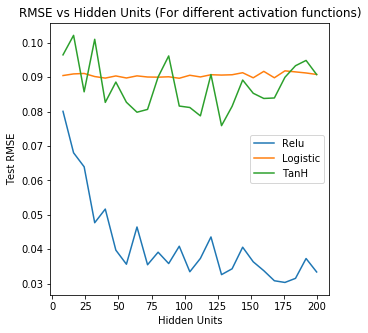

In [11]:
hidden_units = []
for i in range(1,26):
    hidden_units.append(i*8)
    
plot_nn_results(logistic_results[1],relu_results[1],tanh_results[1], hidden_units)


#### From the above graph we can observe that the best results are observed with the 'relu' activation function

### Optimal number of hidden units

In [12]:
#Hidden units
optimal_hidden_units = hidden_units[relu_results[1].index(min(relu_results[1]))]

print('The best combination belongs to relu and %d hidden units with a test RMSE of: %f and training rmse of %f' 
      % (optimal_hidden_units,min(relu_results[1]),relu_results[0][relu_results[1].index(min(relu_results[1]))]))

The best combination belongs to relu and 176 hidden units with a test RMSE of: 0.030340 and training rmse of 0.018999


### Scatter plots for Neural Network

In [40]:
#Scatter plots
mlp_reg_nn = MLPRegressor(hidden_layer_sizes = (optimal_hidden_units), activation = 'relu', verbose = False)

nn_data = pd.read_csv('data/dataset-32.csv')
X = nn_data.loc[:, nn_data.columns != 'Size']
y = nn_data.loc[:, nn_data.columns == 'Size']

predicted_vals = cross_val_predict(mlp_reg_nn,  X, y, cv=10)
residual_vals = y.values-np.reshape(predicted_vals,(-1,1))
scatter_plot(predicted_vals,y)
scatter_plot_time(predicted_vals,y)
residual_plot(predicted_vals,residual_vals)
residual_plot_time(predicted_vals,residual_vals)


NameError: name 'optimal_hidden_units' is not defined

# Part (2)(d) - Predict Back Up Size for each Workflow

## (i) Basic Linear Regression

Workflow ID = 0
____________________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.04299
Average Test RMSE = 0.04302
Coefficients =  {'Week': -2.0000000000000002e-05, 'BackupStart': 0.020109999999999999, 'FileType': 0.0, 'Day': 0.0042100000000000002}
Intercept = 0.03763


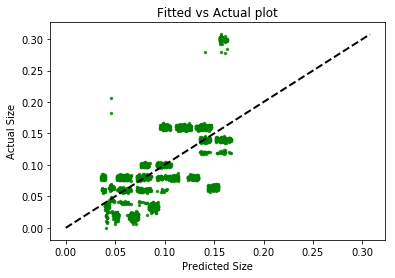

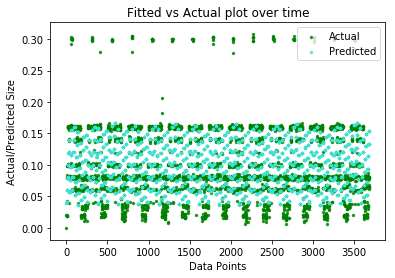

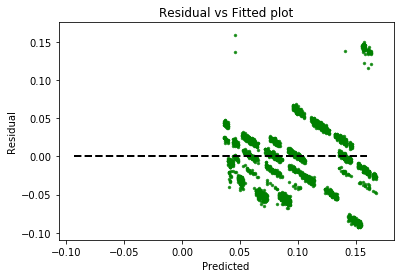

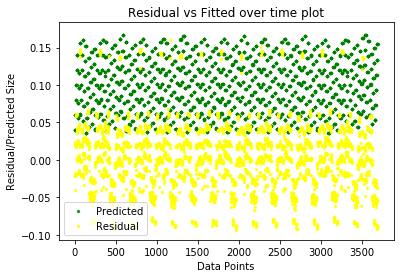

____________________________________________________________
Workflow ID = 1
____________________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.15962
Average Test RMSE = 0.15856
Coefficients =  {'Week': -3.0000000000000001e-05, 'BackupStart': 0.0061999999999999998, 'FileType': 1.0000000000000001e-05, 'Day': -0.01959}
Intercept = 0.09007


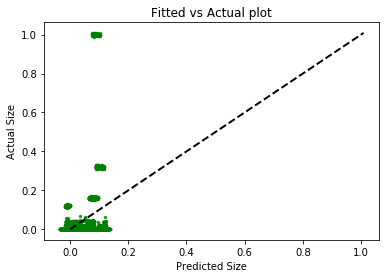

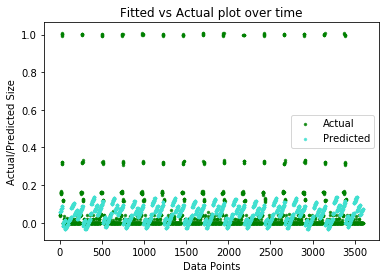

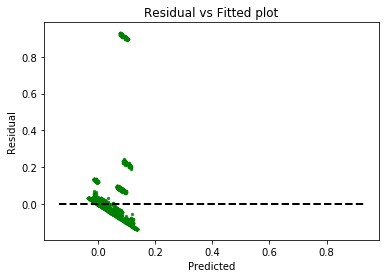

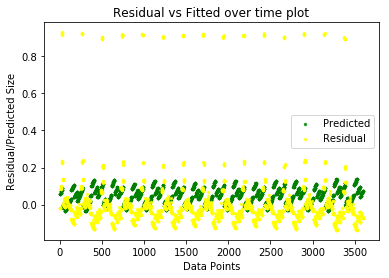

____________________________________________________________
Workflow ID = 2
____________________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.04224
Average Test RMSE = 0.04224
Coefficients =  {'Week': 4.0000000000000003e-05, 'BackupStart': 0.0038700000000000002, 'FileType': 0.00027999999999999998, 'Day': -0.0050099999999999997}
Intercept = 0.02424


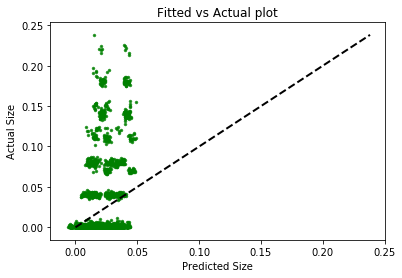

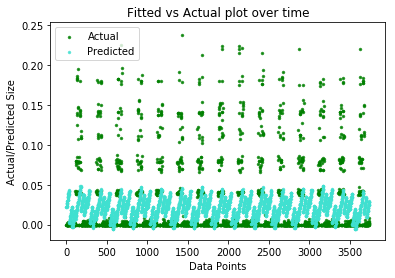

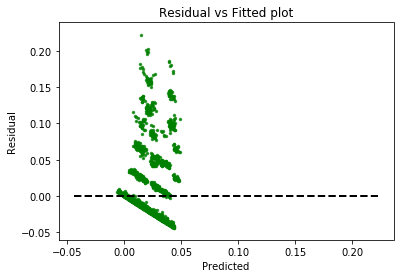

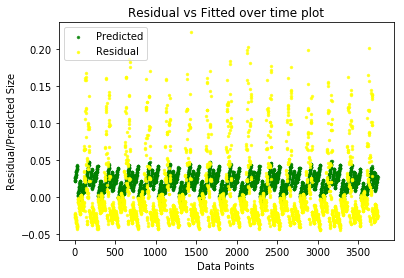

____________________________________________________________
Workflow ID = 3
____________________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.00712
Average Test RMSE = 0.00712
Coefficients =  {'Week': 0.0, 'BackupStart': 0.00035, 'FileType': 0.0, 'Day': -0.00077999999999999999}
Intercept = 0.00553


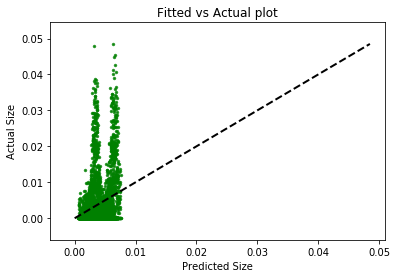

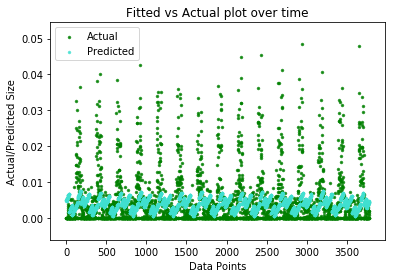

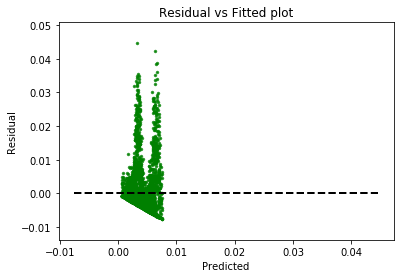

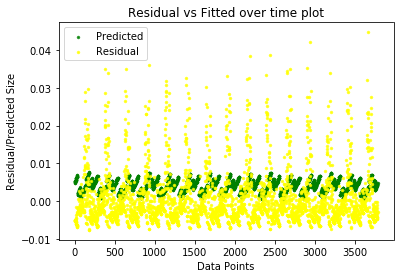

____________________________________________________________
Workflow ID = 4
____________________________________________________________
Pipeline(memory=None,
     steps=[('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average Train RMSE = 0.10302
Average Test RMSE = 0.10297
Coefficients =  {'Week': 6.9999999999999994e-05, 'BackupStart': -0.00156, 'FileType': -2.0000000000000002e-05, 'Day': -0.0066800000000000002}
Intercept = 0.15764


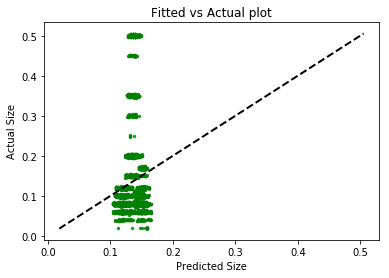

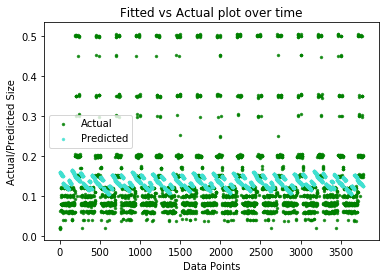

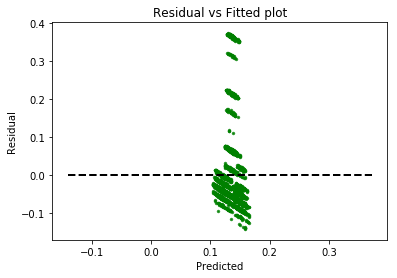

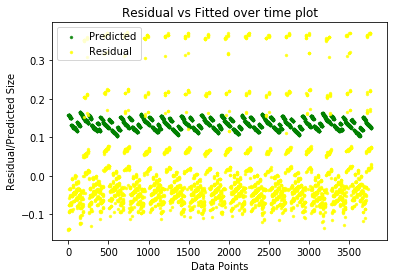

____________________________________________________________
Avg Train RMSE = 0.070998
Train RMSEs = [0.04299, 0.15962000000000001, 0.04224, 0.0071199999999999996, 0.10302]
Avg Test RMSE = 0.070782
Test RMSEs = [0.043020000000000003, 0.15856000000000001, 0.04224, 0.0071199999999999996, 0.10297000000000001]


In [42]:
numerical_data = pd.read_csv('data/dataset-1.csv')
multi_wfid_data = {k: v.reset_index() for k, v in numerical_data.groupby('WFID')}
train_rmse = []
test_rmse = []
for wfid,wfid_data in multi_wfid_data.items():
    print('Workflow ID =', wfid)
    print('_'*60)
    X = wfid_data.loc[:, wfid_data.columns != 'Size']
    X.drop(['WFID','index'],axis=1,inplace=True)
    y = wfid_data.loc[:, wfid_data.columns == 'Size']
    lr = Pipeline([('regression',LinearRegression())])
    train,test = linear_regression2(lr,X,y,cv=10,verbose=False)
    train_rmse.append(train)
    test_rmse.append(test)
    standard_predicted = cross_val_predict(lr,  X, y, cv=10)
    standard_residual = y.values-standard_predicted

    scatter_plot(standard_predicted,y,color='green')
    scatter_plot_time(standard_predicted,y,color='green')
    residual_plot(standard_predicted,standard_residual,color='green')
    residual_plot_time(standard_predicted,standard_residual,color='green')
    print('_'*60)

print('Avg Train RMSE =',np.mean(train_rmse))
print('Train RMSEs =',train_rmse)
print('Avg Test RMSE =',np.mean(test_rmse))
print('Test RMSEs =',test_rmse)

## (ii) Polynomial Regression

0
1
2
3
4
5
6
7
8
9


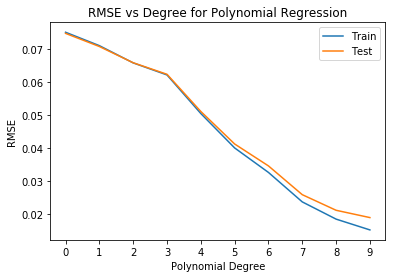

Best Polynomial Regression for degree 9
Test RMSE = 0.01887
Train RMSE = 0.015132


In [36]:
train_rmse = []
test_rmse = []

max_poly_degree=12

for poly_degree in range(max_poly_degree):
    print(poly_degree)
    poly_train_rmse,poly_test_rmse = [],[]
    for wfid,wfid_data in multi_wfid_data.items():
        X = wfid_data.loc[:, wfid_data.columns != 'Size']
        X.drop(['WFID','index'],axis=1,inplace=True)
        y = wfid_data.loc[:, wfid_data.columns == 'Size']
        """poly = PolynomialFeatures(degree=2)
        X_ = poly.fit_transform(X)
        X_test_ = poly.fit_transform(X_test)"""
        model = Pipeline([('poly',PolynomialFeatures(degree=poly_degree)),('regression',LinearRegression())])
        train,test = linear_regression2(model,X,y,cv=10,verbose=False,printing=False)
        poly_train_rmse.append(train)
        poly_test_rmse.append(test)
    train_rmse.append(np.mean(poly_train_rmse))
    test_rmse.append(np.mean(poly_test_rmse))

fig = plt.figure()    
plt.plot(train_rmse,label='Train')
plt.plot(test_rmse,label='Test')
plt.xlabel('Polynomial Degree')
plt.xticks(np.arange(max_poly_degree),list(range(max_poly_degree)))
plt.ylabel('RMSE')
plt.title('RMSE vs Degree for Polynomial Regression')
plt.legend(loc='best')
plt.show()
index = np.argmin(test_rmse)
print('Best Polynomial Regression for degree',index)
print('Test RMSE =',min(test_rmse))
print('Train RMSE =',min(train_rmse))

WFID =  0


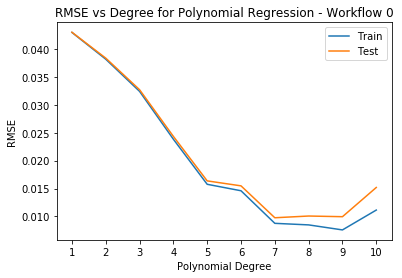

Best Polynomial Regression for degree 7


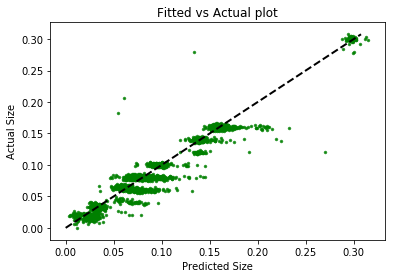

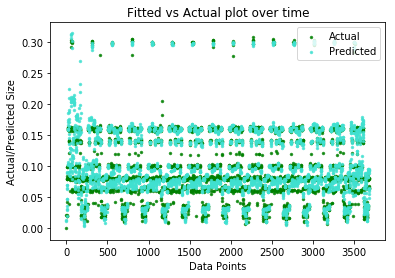

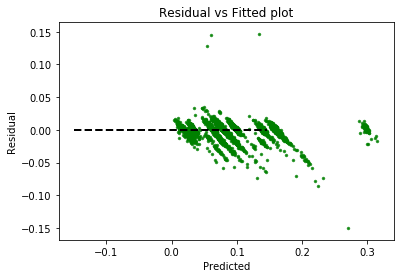

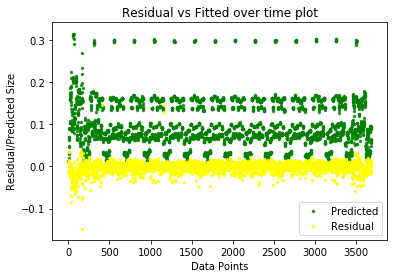

Train RMSE = [0.04299, 0.03819, 0.03242, 0.02384, 0.01576, 0.0146, 0.00876, 0.00848, 0.00758, 0.01114]
Test RMSE = [0.04302, 0.03838, 0.03272, 0.02435, 0.01637, 0.01548, 0.00976, 0.01007, 0.00995, 0.01519]
WFID =  1


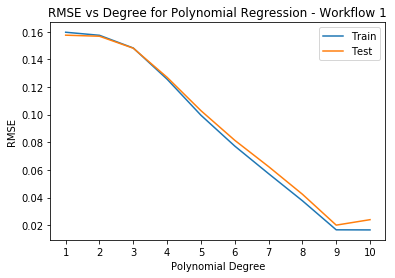

Best Polynomial Regression for degree 9


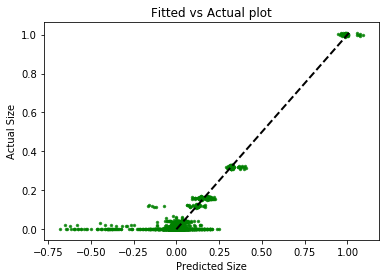

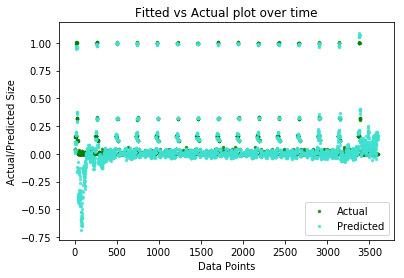

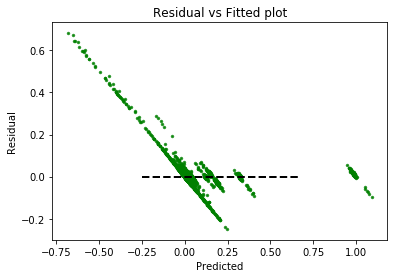

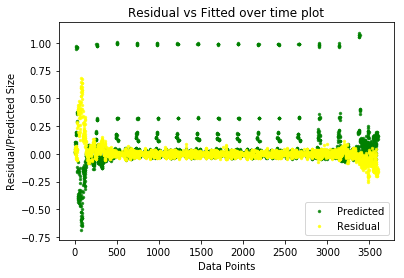

Train RMSE = [0.1596, 0.15739, 0.14819, 0.12563, 0.09958, 0.07728, 0.05732, 0.03773, 0.0167, 0.01663]
Test RMSE = [0.15748, 0.1567, 0.14804, 0.12698, 0.10288, 0.08145, 0.06243, 0.04245, 0.02009, 0.02404]
WFID =  2


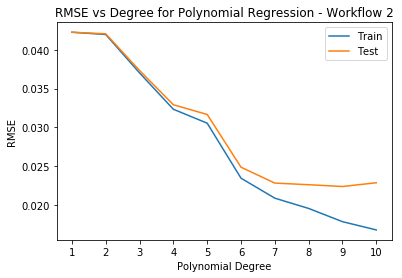

Best Polynomial Regression for degree 9


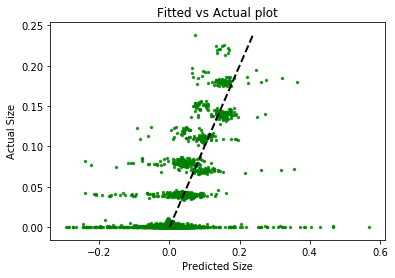

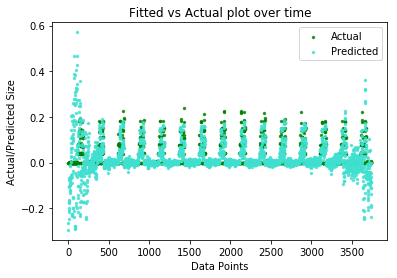

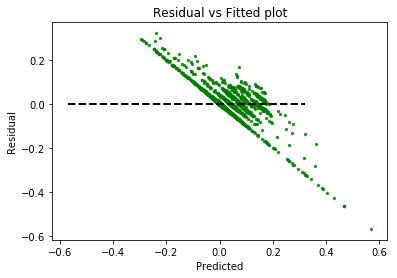

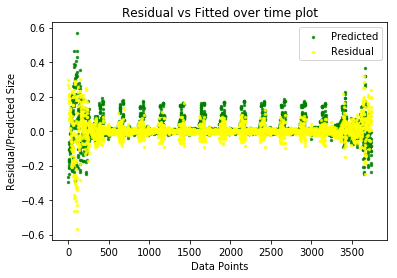

Train RMSE = [0.04224, 0.04195, 0.03701, 0.03234, 0.03055, 0.02348, 0.02091, 0.01959, 0.01789, 0.01683]
Test RMSE = [0.04224, 0.04204, 0.03732, 0.03292, 0.03167, 0.02489, 0.02285, 0.02264, 0.02241, 0.02289]
WFID =  3


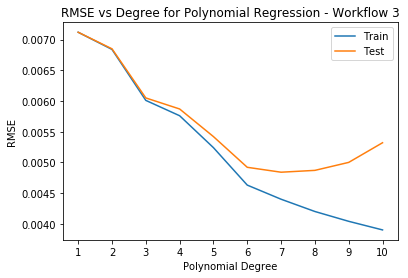

Best Polynomial Regression for degree 7


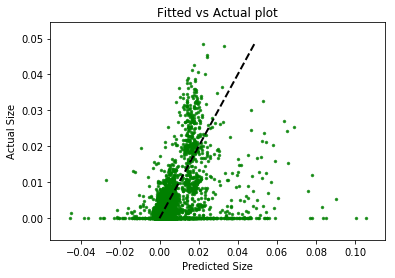

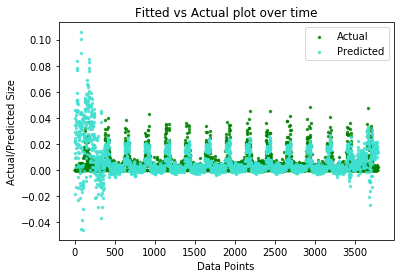

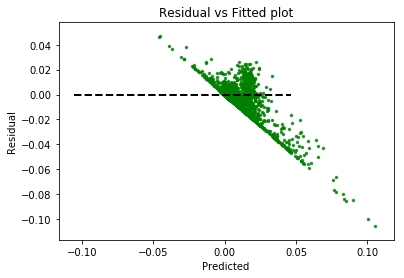

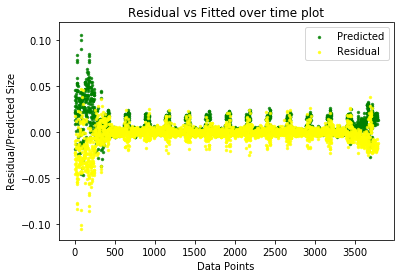

Train RMSE = [0.00712, 0.00684, 0.00601, 0.00576, 0.00524, 0.00463, 0.0044, 0.0042, 0.00404, 0.0039]
Test RMSE = [0.00712, 0.00685, 0.00605, 0.00587, 0.00542, 0.00492, 0.00484, 0.00487, 0.005, 0.00532]
WFID =  4


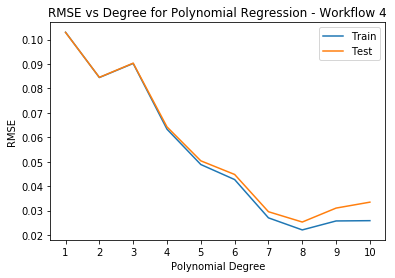

Best Polynomial Regression for degree 8


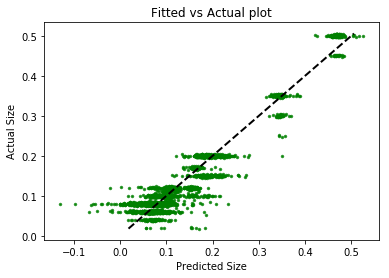

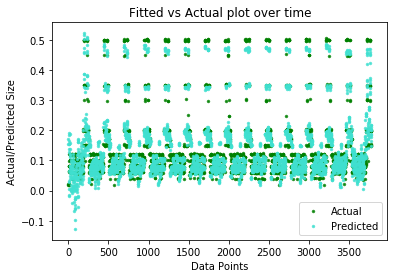

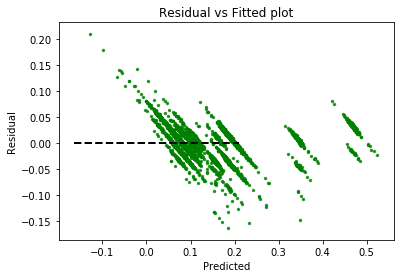

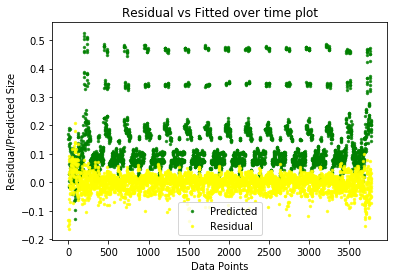

Train RMSE = [0.10301, 0.08447, 0.09023, 0.06331, 0.04884, 0.04268, 0.027, 0.02206, 0.02573, 0.02585]
Test RMSE = [0.10295, 0.08453, 0.09035, 0.06424, 0.05035, 0.04477, 0.02951, 0.02529, 0.031, 0.03343]


In [48]:
max_poly_degree=11

for wfid,wfid_data in multi_wfid_data.items():
    print('WFID = ',wfid)
    X = wfid_data.loc[:, wfid_data.columns != 'Size']
    X.drop(['WFID','index'],axis=1,inplace=True)
    y = wfid_data.loc[:, wfid_data.columns == 'Size']
    poly_train_rmse,poly_test_rmse = [],[]
    for poly_degree in range(1,max_poly_degree):
        model = Pipeline([('poly',PolynomialFeatures(degree=poly_degree)),('regression',LinearRegression())])
        train,test = linear_regression2(model,X,y,cv=10,verbose=False,printing=False)
        poly_train_rmse.append(train)
        poly_test_rmse.append(test)
    fig = plt.figure()    
    plt.plot(poly_train_rmse,label='Train')
    plt.plot(poly_test_rmse,label='Test')
    plt.xlabel('Polynomial Degree')
    plt.xticks(np.arange(max_poly_degree-1),list(range(1,max_poly_degree)))
    plt.ylabel('RMSE')
    plt.title('RMSE vs Degree for Polynomial Regression - Workflow '+str(wfid))
    plt.legend(loc='best')
    plt.show()
    index = np.argmin(poly_test_rmse)
    print('Best Polynomial Regression for degree',index+1)
    model = Pipeline([('poly',PolynomialFeatures(degree=index+1)),('regression',LinearRegression())])
    standard_predicted = cross_val_predict(model,  X, y, cv=10)
    standard_residual = y.values-standard_predicted

    scatter_plot(standard_predicted,y,color='green')
    scatter_plot_time(standard_predicted,y,color='green')
    residual_plot(standard_predicted,standard_residual,color='green')
    residual_plot_time(standard_predicted,standard_residual,color='green')
    print('Train RMSE =',[float(Decimal("%.5f" % e)) for e in poly_train_rmse])
    print('Test RMSE =',[float(Decimal("%.5f" % e)) for e in poly_test_rmse])
    

## 2(e) K-Nearest Neighbour

In [13]:
def knn(X,y,verbose = False):
    average_train_rmse = []
    average_test_rmse = []
    
    for k_value in range(1,20):
    
        knn_regressor = KNeighborsRegressor(n_neighbors=k_value)
        print('\nK Value = %d\n' % (k_value))
        print('_'*40)
        scoring=['neg_mean_squared_error']
        scores = cross_validate(knn_regressor,  X, y, cv=10, scoring=scoring,
                                return_train_score=True)
    
        train_rmse = np.sqrt(np.abs(scores['train_neg_mean_squared_error']))
        test_rmse = np.sqrt(np.abs(scores['test_neg_mean_squared_error']))
    
        average_train_rmse.append(np.mean(train_rmse))
        average_test_rmse.append(np.mean(test_rmse))
        
    return [average_train_rmse , average_test_rmse]
    

In [14]:
load_data = True
if not load_data:
    numerical_data = pd.read_csv('data/dataset-1.csv')
    X = numerical_data.loc[:, numerical_data.columns != 'Size'].as_matrix()
    y = numerical_data.loc[:, numerical_data.columns == 'Size'].as_matrix().ravel()
    rmse_results = knn(X,y,False)
    
    with open('models/knn_rmse.pkl', 'wb') as f:
        dump(rmse_results, f)
        
else:
    with open('models/knn_rmse.pkl', 'rb') as f:
        rmse_results = load(f)

In [15]:
def plot_knn_results(rmse_results, k_values):
    plt.figure(figsize=(5,5))
    plt.plot(k_values, rmse_results, label='KNN')
    plt.xlabel('Num. of Neighbours')
    plt.ylabel('Test RMSE')
    plt.title('RMSE vs Number of Neighbours')
    plt.legend(loc="best")
    plt.show()

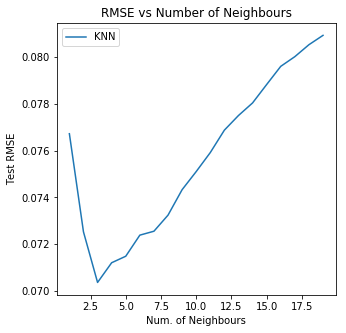

From the graph we can observe that the optimal value for no. of neighbours is: 3

For N = 3 we get a test rmse of 0.070366 and a training rmse of 0.036799


In [17]:
k_values = []
for i in range(1,20):
    k_values.append(i)
    
plot_knn_results(rmse_results[1], k_values)

optimal_k = k_values[rmse_results[1].index(min(rmse_results[1]))]
print('From the graph we can observe that the optimal value for no. of neighbours is: %d' % optimal_k)
print('\nFor N = 3 we get a test rmse of %f and a training rmse of %f' 
      % (min(rmse_results[1]),rmse_results[0][rmse_results[1].index(min(rmse_results[1]))]))

### Scatter plot for KNN

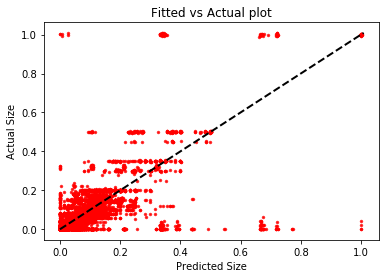

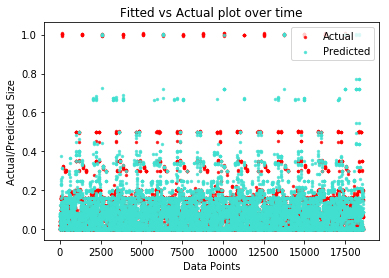

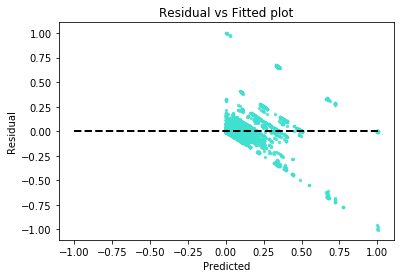

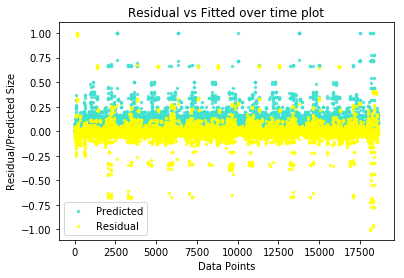

In [44]:
#Scatter plots
knn_regressor = KNeighborsRegressor(n_neighbors=optimal_k)

numerical_data = pd.read_csv('data/dataset-1.csv')
X = numerical_data.loc[:, numerical_data.columns != 'Size']
y = numerical_data.loc[:, numerical_data.columns == 'Size']

predicted_vals = cross_val_predict(knn_regressor,  X, y, cv=10)
residual_vals = y.values-predicted_vals
scatter_plot(predicted_vals,y)
scatter_plot_time(predicted_vals,y)
residual_plot(predicted_vals,residual_vals)
residual_plot_time(predicted_vals,residual_vals)